rework of ch_9_2_cnns_6.ipnynb for (almost) last modelling  
utilizing csv instead of loading as images   
balanced dataset  
ult. 15x20 // balanced CNN 1D LSTM // 3 - Live Data vs PerfectFam vs StreakMM  

# IMPORTS

In [3]:
import random
import pickle
import glob

import random
import ast
import pathlib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# import matplotlib.transforms as transforms

from collections import Counter

from time import time
from time import sleep
from time import strftime
from time import localtime
from tqdm import tqdm

from datetime import date, timedelta, datetime

# from mydecorators import logger, stopwatch

from PIL import Image



In [4]:
import torch
import torch.nn as nn
import torchvision

import torch.nn.functional as F

import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset

import matplotlib.pyplot as plt



# Read CSV of All Data

In [6]:
df_alldata = pd.read_csv('../combined_dataset.csv')
# display(df_alldata)

In [7]:
df_alldata.head()

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,1,0,0,0,1,2,perfectmm_456_0
1,1,0,1,1,0,0,1,1,0,0,...,1,0,1,0,1,1,1,0,2,perfectmm_456_1
2,1,1,1,0,1,0,1,0,0,0,...,1,0,0,1,0,1,1,0,2,perfectmm_456_2
3,1,1,1,1,1,1,1,0,1,0,...,0,1,1,0,0,1,0,1,2,perfectmm_456_3
4,1,0,0,0,0,0,0,1,1,1,...,1,0,0,0,1,0,1,1,2,perfectmm_456_4


# Prepare Dataframes
- Remove Live Data (0)  
- Check Labels ...   
=>  
Live Data : 0  
NearPerfectMM : 1    
PerfectMM : 2  
StreakMM : 3  

In [9]:
df_w_live = df_alldata.copy()

# display(df_wo_live)

## Check current labels

In [11]:
orig_labels = list(df_w_live['labels'])

In [12]:
len(orig_labels)

132127

In [13]:
set(orig_labels)
### 0: live_data
### 1: nearperfectmm
### 2: perfectmm
### 3: streakmm

{0, 1, 2, 3}

## Relabel Accordingly
live_data 0 -> 0  
nearperfectmm 1 -> 1  
perfectmm 2 -> 1   
streakmm 3 -> 2

In [15]:
replaced_labels = [1 if x==2 else x for x in orig_labels]
set(replaced_labels)

{0, 1, 3}

In [16]:
replaced_labels = [2 if x==3 else x for x in replaced_labels]
set(replaced_labels)

{0, 1, 2}

In [17]:
df_w_live['labels'] = replaced_labels

In [18]:
set(df_w_live['labels'])

{0, 1, 2}

## Display Current Dataframe

In [20]:
df_w_live[df_w_live['labels']==0].head(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
90000,1,1,1,0,1,1,1,0,1,0,...,0,1,1,1,0,1,1,0,0,좋은챔프
90001,0,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,1,1,1,0,진기장판


In [21]:
df_w_live[df_w_live['labels']==0].tail(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
132125,0,0,0,1,1,0,1,1,0,0,...,0,1,0,1,0,1,1,1,0,너가능성잇써
132126,0,1,0,1,0,1,1,0,1,1,...,0,0,0,0,0,1,1,0,0,토꽃


In [22]:
df_w_live[df_w_live['labels']==1].head(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,1,0,0,0,1,1,perfectmm_456_0
1,1,0,1,1,0,0,1,1,0,0,...,1,0,1,0,1,1,1,0,1,perfectmm_456_1


In [23]:
df_w_live[df_w_live['labels']==1].tail(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
59998,1,0,1,0,1,1,1,1,0,0,...,1,1,0,1,1,1,1,1,1,nearperfectmm_457_998
59999,0,1,1,1,0,0,1,0,0,1,...,1,1,1,0,1,1,0,1,1,nearperfectmm_457_999


In [24]:
df_w_live[df_w_live['labels']==2].head(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
60000,0,1,0,0,0,0,0,1,1,0,...,1,1,1,1,1,1,1,1,2,streakmm_412_0
60001,1,1,1,1,1,1,0,0,0,0,...,0,1,0,1,1,1,1,1,2,streakmm_412_1


In [25]:
df_w_live[df_w_live['labels']==2].tail(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
89998,1,1,1,1,1,1,1,1,1,1,...,1,1,0,0,0,0,0,0,2,streakmm_386_998
89999,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,0,0,0,2,streakmm_386_999


In [26]:
df_w_live[df_w_live['labels']==3].head(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths


In [27]:
### Live Data
len(df_w_live[df_w_live['labels']==0])

42127

In [28]:
### PerfectMM & NearPerfectMM (PerfectFam)
len(df_w_live[df_w_live['labels']==1])

60000

In [29]:
### StreakMM
len(df_w_live[df_w_live['labels']==2])

30000

## Sample from Groups

### from Live Data

In [32]:
train_livedata = df_w_live[df_w_live['labels']==0].sample(n=20000, random_state=10)

In [33]:
train_livedata.head(3)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
128105,0,0,0,0,0,0,0,1,0,1,...,1,1,1,1,1,0,0,1,0,오젠트리안
128363,0,0,1,1,0,0,1,0,1,1,...,1,0,0,0,0,1,1,0,0,01수영
121491,0,1,0,0,0,0,1,1,1,1,...,0,0,1,0,1,1,0,1,0,무현스님


### from PerfectFam

In [35]:
train_perfectfam = df_w_live[df_w_live['labels']==1].sample(n=20000, random_state=10)

In [36]:
train_perfectfam.head(3)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
4883,0,0,0,0,1,0,0,1,1,0,...,0,1,1,0,0,0,1,1,1,perfectmm_94_883
28477,0,0,0,0,0,0,1,1,1,0,...,0,1,1,1,0,0,1,1,1,perfectmm_712_477
8527,1,0,0,1,0,1,0,1,0,1,...,0,1,0,0,1,0,0,1,1,perfectmm_999_527


### from StreakMM

In [38]:
train_streakmm = df_w_live[df_w_live['labels']==2].sample(n=20000, random_state=10)

In [39]:
train_streakmm.head(3).head(3)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
80412,1,1,1,1,1,1,1,1,1,0,...,0,1,0,0,0,0,0,0,2,streakmm_4_412
61296,0,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,2,streakmm_229_296
63906,1,1,1,1,1,1,0,0,0,0,...,1,1,0,0,0,0,1,0,2,streakmm_14_906


### Get df_train (3 dfs into 1)

In [41]:
df_train = pd.concat([train_livedata, train_perfectfam, train_streakmm])

In [42]:
display(df_train.head(3))
print(len(df_train))

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
128105,0,0,0,0,0,0,0,1,0,1,...,1,1,1,1,1,0,0,1,0,오젠트리안
128363,0,0,1,1,0,0,1,0,1,1,...,1,0,0,0,0,1,1,0,0,01수영
121491,0,1,0,0,0,0,1,1,1,1,...,0,0,1,0,1,1,0,1,0,무현스님


60000


### Get df_test

In [44]:
### indices of df_train
train_idx = list(df_train.index)
len(train_idx)

60000

In [45]:
### indices of df_w_live
df_w_live_idx = list(df_w_live.index)
len(df_w_live_idx)

132127

In [46]:
### df_w_live_idx - train_idx
test_idx = list(set(df_w_live_idx)-set(train_idx))
len(test_idx)

72127

In [47]:
df_test = df_w_live.loc[test_idx]
display(df_test.head(3))
display(df_test.tail(3))
print(len(df_test))

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
131072,0,0,0,1,0,1,1,0,1,0,...,1,0,1,0,0,1,1,0,0,히읏차
2,1,1,1,0,1,0,1,0,0,0,...,1,0,0,1,0,1,1,0,1,perfectmm_456_2
3,1,1,1,1,1,1,1,0,1,0,...,0,1,1,0,0,1,0,1,1,perfectmm_456_3


,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
131065,1,1,1,0,1,0,1,0,0,0,...,0,1,0,0,0,1,1,0,0,신은없으니깐
131069,0,1,1,1,1,1,0,1,1,0,...,1,0,1,1,0,1,1,1,0,묘목있어요
131071,0,0,0,0,0,1,1,1,0,1,...,0,0,1,0,0,1,1,1,0,민쵸트코


72127


In [48]:
# df = df_w_live[df_w_live['labels']==2].sample(n=1, random_state=11)

In [49]:
# df

In [50]:
# ddf = df_w_live[df_w_live['labels']==2].sample(n=2, random_state=10)

In [51]:
# ddf

In [52]:
# dddf = pd.concat([df,ddf])

In [53]:
# dddf

In [54]:
# dddf.reset_index(drop=True)

In [55]:
# dddf = dddf.reset_index(drop=False)

In [56]:
# dddf 

In [57]:
# sorted(list(dddf.index))

In [58]:
# df_w_live[df_w_live['labels']==2].loc[[61296, 76131, 80412]]

In [59]:
# del dddf

# Create Pytorch Dataset (custom)

## Define Dataset Class

In [62]:
# Custom Dataset Class
## Needs AT LEAST 3 class methods
## __init__, __len__, __getitem__

class RecordsDataset(Dataset):
    # This loads the data and converts it, make data rdy
    def __init__(self, pd_df):
        # load data
        self.df=pd_df
        # extract labels
        self.df_labels=self.df[['labels']]
        # drop non numeric columns to make tutorial simpler, in real life do categorical encoding
        # self.df=df.drop(columns=['Type','Color','Spectral_Class'])
        
        # convert to torch dtypes
        # self.dataset = self.df[[0,1]]
        # self.dataset=torch.tensor(self.df[[i for i in range(300)]].to_numpy()).float()
        self.dataset=torch.tensor(self.df[[str(i) for i in range(300)]].to_numpy()).float()
        # self.dataset = self.df[[str(i) for i in range(10)]]
        
        self.labels=torch.tensor(self.df_labels.to_numpy().reshape(-1))
    
    # This returns the total amount of samples in your Dataset
    def __len__(self):
        return len(self.dataset)
    
    # This returns given an index the i-th sample and label
    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx]

## Instantiate Dataset Class

In [64]:
# all_dataset = RecordsDataset(df_w_live)
train_alldataset = RecordsDataset(df_train)

In [65]:
test_alldataset = RecordsDataset(df_test)

## Split Train & Test

In [67]:
# train_size = int(0.7 * len(all_dataset))
# test_size = len(all_dataset) - train_size
# # train_alldataset, test_alldataset = torch.utils.data.random_split(all_dataset, [train_size, test_size])

# train_alldataset, test_alldataset = torch.utils.data.random_split(all_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(12))
# ### torch.Generator().manual_seed(42)

In [68]:
# train_alldataset
# len(train_alldataset)

In [69]:
# test_alldataset
# len(test_alldataset)

## Create Train & Test all_dataloaders

In [71]:
train_alldataloader = torch.utils.data.DataLoader(train_alldataset, batch_size=32, shuffle=True)

In [72]:
test_alldataloader = torch.utils.data.DataLoader(test_alldataset, batch_size=32, shuffle=False)

### Check Train alldataloader

In [74]:
for images, labels in train_alldataloader:
    break

# images, labels = next(iter(dataloader))

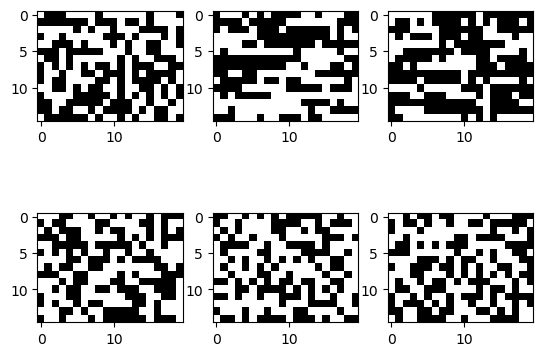

In [75]:
examples = iter(train_alldataloader)
# example_data, example_targets = examples.next()
example_data, example_targets = next(examples)

# example_data.shape
# example_data[0].reshape(15,20)


for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i].reshape(15,20), cmap='gray')
    # print(example_targets)
plt.show()

In [76]:
print(example_targets)

tensor([0, 2, 2, 0, 1, 1, 2, 0, 2, 0, 0, 0, 1, 0, 1, 1, 1, 2, 1, 1, 0, 0, 2, 0,
        1, 0, 1, 1, 0, 1, 0, 0])


### Check Test alldataloader

In [78]:
for images, labels in test_alldataloader:
    break

# images, labels = next(iter(dataloader))

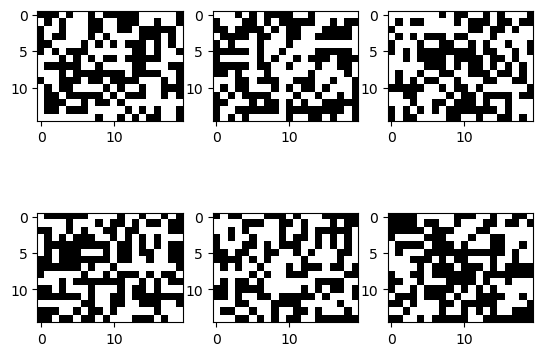

In [79]:
examples = iter(test_alldataloader)
# example_data, example_targets = examples.next()
example_data, example_targets = next(examples)


for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i].reshape(15,20), cmap='gray')
    # print(example_targets)
plt.show()

In [80]:
print(example_targets)

tensor([0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 0, 1, 0, 1, 1])


# Create First CNN
- Live Data vs (PerfectMM & NearPerfectMM) v StreakMM


## Configurations (Hyperparameters)

In [1374]:
# Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Hyper-parameters
input_size = 15*20 # originally 348x465 before resize

num_classes = 3


# num_epochs = 1
# num_epochs = 2
# num_epochs = 10
# num_epochs = 20
num_epochs = 50
# num_epochs = 100
# num_epochs = 300
# num_epochs = 500
# num_epochs = 1000

# learning_rate = 0.0001
learning_rate = 0.0003
# learning_rate = 0.001

In [1375]:
print(device)

mps


## Define Model

In [1377]:
### variation of ...
### cnn_flat_v8.1_lstm_1drop_10epo.pth
### cnn_flat_v8.2_lstm_1drop_300epo.pth


class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
            
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0, return_indices=False)
        
        ###
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding='same')
        
        self.lstm1 = nn.LSTM(input_size=150, batch_first=True, bidirectional=True, hidden_size=128, num_layers=1)
        
        ###
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding='same')
        
        self.lstm2 = nn.LSTM(input_size=128, batch_first=True, bidirectional=True, hidden_size=32, num_layers=1)
        
        ###
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, padding='same')
        
        self.lstm3 = nn.LSTM(input_size=32, batch_first=True, bidirectional=True, hidden_size=16, num_layers=1)
        
        ###
        self.fc1 = nn.Linear(512, 256)
        
        self.fc2 = nn.Linear(256, 128)
        
        self.fc_final = nn.Linear(128, num_classes)

        # self.fc1 = nn.Linear(2*8*128, 512)
            
            
#         # self.pool = nn.MaxPool1d(kernel_size=2, stride=1, padding=0, return_indices=False)
#         # self.pool1 = nn.MaxPool1d(kernel_size=4, stride=2, padding=0, return_indices=False)
#         self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0, return_indices=False)
        
        
#         self.conv1 = nn.Conv1d(in_channels=1, out_channels=128, kernel_size=3, padding='same')
#         # self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
        
#         self.conv2 = nn.Conv1d(in_channels=128, out_channels=32, kernel_size=5, padding='same')
#         # self.conv2 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3)
#         # self.conv2.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(128, 256, 3)
        
#         self.conv3 = nn.Conv1d(in_channels=32, out_channels=8, kernel_size=7, padding='same')
#         # self.conv3 = nn.Conv1d(in_channels=16, out_channels=8, kernel_size=3)
#         # # self.conv3.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(64, 128, 3)
        
        
#         self.fc1 = nn.Linear(2*8*128, 512)
#         self.fc2 = nn.Linear(512, 128)
#         self.fc3 = nn.Linear(128, 32)
        
#         # self.lstm1 = nn.LSTM(input_size=37, batch_first=True, bidirectional=False, hidden_size=128, num_layers=1)
#         self.lstm1 = nn.LSTM(input_size=37, batch_first=True, bidirectional=True, hidden_size=128, num_layers=1)
        
#         # self.lstm1 = nn.LSTM(input_size=128, batch_first=True, bidirectional=True, hidden_size=64, num_layers=2, dropout=0.25)
#         # self.lstm2 = nn.LSTM(input_size=128, batch_first=True, bidirectional=False, hidden_size=64)
#         # self.lstm3 = nn.LSTM(input_size=64, batch_first=True, bidirectional=False, hidden_size=32)
        
        
#         self.fc_final = nn.Linear(32, num_classes)
        
#         self.drop1 = nn.Dropout(p=0.3)
#         # self.drop2 = nn.Dropout(p=0.3)
        

    def forward(self, x):
        # print(f'starting shape : {x.shape}')       # batch_size, 300
        
        x = x.reshape(-1, 1, 300)       # -> batch_size, 1, 300
        # print(x.shape)      
        
        x = F.relu(self.conv1(x))       # -> batch_size, 64, 300
        # print(x.shape)
        
        x = self.pool(x)       # -> batch_size, 64, 150
        # print(x.shape)
        
        x, _ = self.lstm1(x)     # -> batch_size, 64, 2 * 128
        # print(f'lstm1: {x.shape}')
        
        x = F.relu(self.conv2(x))       # -> batch_size, 32, 2 * 128
        # print(x.shape)
        
        x = self.pool(x)       # -> batch_size, 32, 128
        # print(x.shape)
        
        x, _ = self.lstm2(x)     # -> batch_size, 32, 2 * 32
        # print(f'lstm2: {x.shape}')
        
        x = F.relu(self.conv3(x))       # -> batch_size, 16, 64
        # print(x.shape)
        
        x = self.pool(x)       # -> batch_size, 16, 32
        # print(x.shape)
        
        x, _ = self.lstm3(x)     # -> batch_size, 16, 32
        # print(f'lstm3: {x.shape}')
        
        x = torch.flatten(x, 1)     # -> batch_size, 512
        # print(f'flatten: {x.shape}')
        
        x = F.relu(self.fc1(x))       # -> batch_size, 256
        # print(x.shape)
        
        x = F.relu(self.fc2(x))       # -> batch_size, 128
        # print(x.shape)
        
        x = self.fc_final(x)       # -> batch_size, 3
        # print(x.shape)
        
        
        
#         x = x.reshape(-1, 1, 300)
#         # print(x.shape)      # batch_size, 1, 300
        
#         x = F.relu(self.conv1(x))   # -> batch_size, 32, 300
#         # print(x.shape)
#         x = self.pool2(x)            # -> batch_size, 32, 150
#         # print(x.shape)
        
#         x = F.relu(self.conv2(x))   # -> batch_size, 16, 150
#         # print(x.shape)
#         x = self.pool2(x)            # -> batch_size, 16, 75
#         # print(x.shape)
        
#         x = F.relu(self.conv3(x))   # -> batch_size, 8, 75
#         # print(x.shape)
        
#         x = self.pool2(x)            # -> batch_size, 8, 37
#         # print(x.shape)

#         # x = torch.flatten(x, 1)     # -> batch_size, 4672
#         # print(f'flatten1: {x.shape}')
        
#         x = self.drop1(x)
        
#         x, _ = self.lstm1(x)     # -> batch_size, 8, 128
#         # print(f'lstm1: {x.shape}')
        
        
#         # x = F.relu(self.fc1(x), 1)     # -> batch_size, 2368
#         # x = self.drop1(x)
#         # print(x.shape)
        
#        # x, _ = self.lstm1(x)     # -> batch_size, 64*2
#        # print(f'lstm1: {x.shape}')
        
#         # x, _ = self.lstm2(x)     # -> batch_size, 16
#         # print(f'lstm2: {x.shape}')
        
        # x = torch.flatten(x, 1)     # -> batch_size, 1024
        # # print(f'flatten2: {x.shape}')
        
#         x = F.relu(self.fc1(x))             # -> batch_size, 128
#         # print(x.shape)
        
#         x = F.relu(self.fc2(x))
#         # print(x.shape)
        
#         x = self.fc3(x)             # -> batch_size, num_classes(=3)
#         # print(x.shape)
    
        
        return x
    
    
    
#######################    
# starting shape : torch.Size([32, 300])
# torch.Size([32, 1, 300])
# torch.Size([32, 64, 300])
# torch.Size([32, 64, 150])
# lstm1: torch.Size([32, 64, 256])
# torch.Size([32, 32, 256])
# torch.Size([32, 32, 128])
# lstm2: torch.Size([32, 32, 64])
# torch.Size([32, 16, 64])
# torch.Size([32, 16, 32])
# lstm3: torch.Size([32, 16, 32])
# flatten: torch.Size([32, 512])
# torch.Size([32, 256])
# torch.Size([32, 128])
# torch.Size([32, 3])

### ~14 seconds per epoch to train (mps, w/ 1 dropout, Adam)

In [1378]:
# ### variation of ...
# ### cnn_flat_v8.1_lstm_1drop_10epo.pth
# ### cnn_flat_v8.2_lstm_1drop_300epo.pth


# class ConvNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # self.pool = nn.MaxPool1d(kernel_size=2, stride=1, padding=0, return_indices=False)
#         # self.pool1 = nn.MaxPool1d(kernel_size=4, stride=2, padding=0, return_indices=False)
#         self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0, return_indices=False)
        
        
#         self.conv1 = nn.Conv1d(in_channels=1, out_channels=128, kernel_size=3, padding='same')
#         # self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
        
#         self.conv2 = nn.Conv1d(in_channels=128, out_channels=32, kernel_size=5, padding='same')
#         # self.conv2 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3)
#         # self.conv2.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(128, 256, 3)
        
#         self.conv3 = nn.Conv1d(in_channels=32, out_channels=8, kernel_size=7, padding='same')
#         # self.conv3 = nn.Conv1d(in_channels=16, out_channels=8, kernel_size=3)
#         # # self.conv3.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(64, 128, 3)
        
        
#         self.fc1 = nn.Linear(2*8*128, 512)
#         self.fc2 = nn.Linear(512, 128)
#         self.fc3 = nn.Linear(128, 32)
        
#         # self.lstm1 = nn.LSTM(input_size=37, batch_first=True, bidirectional=False, hidden_size=128, num_layers=1)
#         self.lstm1 = nn.LSTM(input_size=37, batch_first=True, bidirectional=True, hidden_size=128, num_layers=1)
        
#         # self.lstm1 = nn.LSTM(input_size=128, batch_first=True, bidirectional=True, hidden_size=64, num_layers=2, dropout=0.25)
#         # self.lstm2 = nn.LSTM(input_size=128, batch_first=True, bidirectional=False, hidden_size=64)
#         # self.lstm3 = nn.LSTM(input_size=64, batch_first=True, bidirectional=False, hidden_size=32)
        
        
#         self.fc4 = nn.Linear(32, num_classes)
        
#         self.drop1 = nn.Dropout(p=0.3)
#         # self.drop2 = nn.Dropout(p=0.3)
        

#     def forward(self, x):
#         # print(f'starting shape : {x.shape}')       # batch_size, 300
        
#         x = x.reshape(-1, 1, 300)
#         # print(x.shape)      # batch_size, 1, 300
        
#         x = F.relu(self.conv1(x))   # -> batch_size, 32, 300
#         # print(x.shape)
#         x = self.pool2(x)            # -> batch_size, 32, 150
#         # print(x.shape)
        
#         x = F.relu(self.conv2(x))   # -> batch_size, 16, 150
#         # print(x.shape)
#         x = self.pool2(x)            # -> batch_size, 16, 75
#         # print(x.shape)
        
#         x = F.relu(self.conv3(x))   # -> batch_size, 8, 75
#         # print(x.shape)
        
#         x = self.pool2(x)            # -> batch_size, 8, 37
#         # print(x.shape)

#         # x = torch.flatten(x, 1)     # -> batch_size, 4672
#         # print(f'flatten1: {x.shape}')
        
#         x = self.drop1(x)
        
#         x, _ = self.lstm1(x)     # -> batch_size, 8, 128
#         # print(f'lstm1: {x.shape}')
        
        
#         # x = F.relu(self.fc1(x), 1)     # -> batch_size, 2368
#         # x = self.drop1(x)
#         # print(x.shape)
        
#         # x, _ = self.lstm1(x)     # -> batch_size, 64*2
#         # print(f'lstm1: {x.shape}')
        
#         # x, _ = self.lstm2(x)     # -> batch_size, 16
#         # print(f'lstm2: {x.shape}')
        
#         x = torch.flatten(x, 1)     # -> batch_size, 1024
#         # print(f'flatten2: {x.shape}')
        
#         x = F.relu(self.fc1(x))             # -> batch_size, 128
#         # print(x.shape)
        
#         x = F.relu(self.fc2(x))
#         # print(x.shape)
        
#         x = self.fc3(x)             # -> batch_size, num_classes(=3)
#         # print(x.shape)
    
        
#         return x
    
    
    
# #######################    
# # starting shape : torch.Size([32, 300])
# # torch.Size([32, 1, 300])
# # torch.Size([32, 32, 298])
# # torch.Size([32, 32, 149])
# # torch.Size([32, 16, 147])
# # torch.Size([32, 16, 73])
# # torch.Size([32, 8, 73])
# # torch.Size([32, 8, 36])
# # lstm1: torch.Size([32, 8, 128])
# # flatten2: torch.Size([32, 1024])
# # torch.Size([32, 256])
# # torch.Size([32, 3])

# ### ~14 seconds per epoch to train (mps, w/ 1 dropout, Adam)

In [1379]:
# ### variation of ...
# ### cnn_flat_v8.1_lstm_1drop_10epo.pth
# ### cnn_flat_v8.2_lstm_1drop_300epo.pth


# class ConvNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # self.pool = nn.MaxPool1d(kernel_size=2, stride=1, padding=0, return_indices=False)
#         # self.pool1 = nn.MaxPool1d(kernel_size=4, stride=2, padding=0, return_indices=False)
#         self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0, return_indices=False)
        
        
#         # self.conv1 = nn.Conv1d(in_channels=1, out_channels=128, kernel_size=3, padding='same')
#         self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
        
#         # self.conv2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding='same')
#         self.conv2 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3)
#         # self.conv2.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(128, 256, 3)
        
#         # self.conv3 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding='same')
#         # # self.conv3.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(64, 128, 3)
        
        
#         self.fc1 = nn.Linear(1024, 256)
#         self.fc2 = nn.Linear(256, 64)
        
#         self.lstm1 = nn.LSTM(input_size=73, batch_first=True, bidirectional=False, hidden_size=128, num_layers=1)
#         # self.lstm1 = nn.LSTM(input_size=128, batch_first=True, bidirectional=True, hidden_size=64, num_layers=2, dropout=0.25)
#         # self.lstm2 = nn.LSTM(input_size=128, batch_first=True, bidirectional=False, hidden_size=64)
#         # self.lstm3 = nn.LSTM(input_size=64, batch_first=True, bidirectional=False, hidden_size=32)
        
        
#         self.fc3 = nn.Linear(64, num_classes)
        
#         self.drop1 = nn.Dropout(p=0.3)
#         # self.drop2 = nn.Dropout(p=0.3)
        

#     def forward(self, x):
#         # print(f'starting shape : {x.shape}')       # batch_size, 300
        
#         x = x.reshape(-1, 1, 300)
#         # print(x.shape)      # batch_size, 1, 300
        
#         x = F.relu(self.conv1(x))   # -> batch_size, 4, 298
#         # print(x.shape)
#         x = self.pool2(x)            # -> batch_size, 4, 149
#         # print(x.shape)
        
#         x = F.relu(self.conv2(x))   # -> batch_size, 64, 147
#         # print(x.shape)
#         x = self.pool2(x)            # -> batch_size, 64, 73
#         # print(x.shape)
        
#         # x = F.relu(self.conv3(x))   # -> batch_size, 64, 75
#         # # print(x.shape)
#         # x = self.pool(x)            # -> batch_size, 64, 37
#         # # print(x.shape)

#         # x = torch.flatten(x, 1)     # -> batch_size, 4672
#         # print(f'flatten1: {x.shape}')
        
#         x = self.drop1(x)
        
#         x, _ = self.lstm1(x)     # -> batch_size, 4, 128
#         # print(f'lstm1: {x.shape}')
        
        
#         # x = F.relu(self.fc1(x), 1)     # -> batch_size, 2368
#         # x = self.drop1(x)
#         # print(x.shape)
        
#         # x, _ = self.lstm1(x)     # -> batch_size, 64*2
#         # print(f'lstm1: {x.shape}')
        
#         # x, _ = self.lstm2(x)     # -> batch_size, 16
#         # print(f'lstm2: {x.shape}')
        
#         x = torch.flatten(x, 1)     # -> batch_size, 1024
#         # print(f'flatten2: {x.shape}')
        
#         x = F.relu(self.fc1(x))             # -> batch_size, 128
#         # print(x.shape)
        
#         x = F.relu(self.fc2(x))
        
#         x = self.fc3(x)             # -> batch_size, num_classes(=3)
#         # print(x.shape)
    
        
#         return x
    
    
    
# #######################    
# # starting shape : torch.Size([32, 300])
# # torch.Size([32, 1, 300])
# # torch.Size([32, 16, 298])
# # torch.Size([32, 16, 149])
# # torch.Size([32, 8, 147])
# # torch.Size([32, 8, 73])
# # lstm1: torch.Size([32, 8, 128])
# # flatten2: torch.Size([32, 1024])
# # torch.Size([32, 128])
# # torch.Size([32, 3])

# ### ~14 seconds per epoch to train (mps, w/ 1 dropout, Adam)

In [1380]:
# ### variation of ...
# ### cnn_flat_v8.1_lstm_1drop_10epo.pth
# ### cnn_flat_v8.2_lstm_1drop_300epo.pth


# class ConvNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # self.pool = nn.MaxPool1d(kernel_size=2, stride=1, padding=0, return_indices=False)
#         self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0, return_indices=False)
        
        
#         self.conv1 = nn.Conv1d(in_channels=1, out_channels=256, kernel_size=3, padding='same')
#         # self.conv1.weight.data = torch.Tensor([[[0.1, 0.2, 0.4, 0.2, 0.1]]]).expand(256, 1, 5)
        
#         self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding='same')
#         # self.conv2.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(128, 256, 3)
        
#         self.conv3 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding='same')
#         # self.conv3.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(64, 128, 3)
        
        
#         self.fc1 = nn.Linear(64*37, 16*37)
#         # self.fc2 = nn.Linear(128, 64)
        
#         self.lstm1 = nn.LSTM(input_size=16*37, batch_first=True, bidirectional=False, hidden_size=128, num_layers=1)
#         # self.lstm1 = nn.LSTM(input_size=128, batch_first=True, bidirectional=True, hidden_size=64, num_layers=2, dropout=0.25)
#         self.lstm2 = nn.LSTM(input_size=128, batch_first=True, bidirectional=False, hidden_size=64)
#         self.lstm3 = nn.LSTM(input_size=64, batch_first=True, bidirectional=False, hidden_size=32)
        
        
#         self.fc2 = nn.Linear(32, num_classes)
        
#         self.drop1 = nn.Dropout(p=0.3)
#         # self.drop2 = nn.Dropout(p=0.3)
        

#     def forward(self, x):
#         # print(f'starting shape : {x.shape}')       # batch_size, 300
        
#         x = x.reshape(-1, 1, 300)
#         # print(x.shape)      # batch_size, 1, 300
        
#         x = F.relu(self.conv1(x))   # -> batch_size, 256, 300
#         # print(x.shape)
#         x = self.pool(x)            # -> batch_size, 256, 150
#         # print(x.shape)
        
#         x = F.relu(self.conv2(x))   # -> batch_size, 128, 150
#         # print(x.shape)
#         x = self.pool(x)            # -> batch_size, 128, 75
#         # print(x.shape)
        
#         x = F.relu(self.conv3(x))   # -> batch_size, 64, 75
#         # print(x.shape)
#         x = self.pool(x)            # -> batch_size, 64, 37
#         # print(x.shape)

#         x = torch.flatten(x, 1)     # -> batch_size, 288
#         # print(f'flatten1: {x.shape}')
#         x = self.drop1(x)
        
        
#         x = F.relu(self.fc1(x), 1)     # -> batch_size, 2368
#         # x = self.drop1(x)
#         # print(x.shape)
        
#         x, _ = self.lstm1(x)     # -> batch_size, 64*2
#         # print(f'lstm1: {x.shape}')
        
#         x, _ = self.lstm2(x)     # -> batch_size, 16
#         # print(f'lstm2: {x.shape}')
        
#         x, _ = self.lstm3(x)     # -> batch_size, 16
#         # print(f'lstm2: {x.shape}')
        
#         x = torch.flatten(x, 1)     # -> batch_size, 128
#         # print(f'flatten2: {x.shape}')
        
#         x = self.fc2(x)             # -> batch_size, num_classes(=3)
#         # print(x.shape)
    
        
#         return x
    
    
    
# #######################    
# # starting shape : torch.Size([32, 300])
# # torch.Size([32, 1, 300])
# # torch.Size([32, 128, 300])
# # torch.Size([32, 128, 150])
# # torch.Size([32, 64, 150])
# # torch.Size([32, 64, 75])
# # torch.Size([32, 32, 75])
# # torch.Size([32, 32, 37])
# # flatten1: torch.Size([32, 1184])
# # torch.Size([32, 128])
# # lstm1: torch.Size([32, 64])
# # lstm2: torch.Size([32, 32])
# # flatten2: torch.Size([32, 32])
# # torch.Size([32, 3])


# ### apprx 10 seconds per epoch to train (mps, w/ 1 dropout, Adam)

# ### 10 epochs, initial loss: 0.532, final loss: 0.439 //  mins
# ### 50 epochs // initial loss: 0.542, final loss: 0.185 //  mins
# ### 100 epochs // initial loss: 0.522, final loss: 0.092 //  mins
# ### 300 epochs // initial loss: , final loss:  //  mins
# ### 500 epochs // initial loss: , final loss:  //  mins


In [1381]:
# ### variation of ...
# ### cnn_flat_v8.1_lstm_1drop_10epo.pth
# ### cnn_flat_v8.2_lstm_1drop_300epo.pth


# class ConvNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # self.pool = nn.MaxPool1d(kernel_size=2, stride=1, padding=0, return_indices=False)
#         self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0, return_indices=False)
        
        
#         self.conv1 = nn.Conv1d(in_channels=1, out_channels=256, kernel_size=5, padding='same')
#         # self.conv1.weight.data = torch.Tensor([[[0.1, 0.2, 0.4, 0.2, 0.1]]]).expand(256, 1, 5)
        
#         self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding='same')
#         # self.conv2.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(128, 256, 3)
        
#         self.conv3 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding='same')
#         # self.conv3.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(64, 128, 3)
        
        
#         self.fc1 = nn.Linear(64*37, 128)
#         # self.fc2 = nn.Linear(128, 64)
        
#         self.lstm1 = nn.LSTM(input_size=128, batch_first=True, bidirectional=False, hidden_size=64, num_layers=1)
#         # self.lstm1 = nn.LSTM(input_size=128, batch_first=True, bidirectional=True, hidden_size=64, num_layers=2, dropout=0.25)
#         self.lstm2 = nn.LSTM(input_size=64, batch_first=True, bidirectional=False, hidden_size=32)
        
        
#         self.fc2 = nn.Linear(32, num_classes)
        
#         self.drop1 = nn.Dropout(p=0.3)
#         # self.drop2 = nn.Dropout(p=0.3)
        

#     def forward(self, x):
#         # print(f'starting shape : {x.shape}')       # batch_size, 300
        
#         x = x.reshape(-1, 1, 300)
#         # print(x.shape)      # batch_size, 1, 300
        
#         x = F.relu(self.conv1(x))   # -> batch_size, 256, 300
#         # print(x.shape)
#         x = self.pool(x)            # -> batch_size, 256, 150
#         # print(x.shape)
        
#         x = F.relu(self.conv2(x))   # -> batch_size, 128, 150
#         # print(x.shape)
#         x = self.pool(x)            # -> batch_size, 128, 75
#         # print(x.shape)
        
#         x = F.relu(self.conv3(x))   # -> batch_size, 64, 75
#         # print(x.shape)
#         x = self.pool(x)            # -> batch_size, 64, 37
#         # print(x.shape)

#         x = torch.flatten(x, 1)     # -> batch_size, 288
#         # print(f'flatten1: {x.shape}')
#         x = self.drop1(x)
        
        
#         x = F.relu(self.fc1(x), 1)     # -> batch_size, 2368
#         # x = self.drop1(x)
#         # print(x.shape)
        
#         x, _ = self.lstm1(x)     # -> batch_size, 64*2
#         # print(f'lstm1: {x.shape}')
        
#         x, _ = self.lstm2(x)     # -> batch_size, 16
#         # print(f'lstm2: {x.shape}')
        
#         x = torch.flatten(x, 1)     # -> batch_size, 128
#         # print(f'flatten2: {x.shape}')
        
#         x = self.fc2(x)             # -> batch_size, num_classes(=3)
#         # print(x.shape)
    
        
#         return x
    
    
    
# #######################    
# # starting shape : torch.Size([32, 300])
# # torch.Size([32, 1, 300])
# # torch.Size([32, 256, 300])
# # torch.Size([32, 256, 150])
# # torch.Size([32, 128, 150])
# # torch.Size([32, 128, 75])
# # torch.Size([32, 64, 75])
# # torch.Size([32, 64, 37])
# # flatten1: torch.Size([32, 2368])
# # torch.Size([32, 128])
# # lstm1: torch.Size([32, 64])
# # lstm2: torch.Size([32, 32])


# ### apprx 10 seconds per epoch to train (mps, w/ 1 dropout, Adam)

# ### 10 epochs, initial loss: 0.532, final loss: 0.439 //  mins
# ### 50 epochs // initial loss: 0.542, final loss: 0.185 //  mins
# ### 100 epochs // initial loss: 0.522, final loss: 0.092 //  mins
# ### 300 epochs // initial loss: , final loss:  //  mins
# ### 500 epochs // initial loss: , final loss:  //  mins


In [1382]:
# ### cnn_flat_v8.1_lstm_1drop_10epo.pth
# ### cnn_flat_v8.2_lstm_1drop_300epo.pth


# class ConvNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # self.pool = nn.MaxPool1d(kernel_size=2, stride=1, padding=0, return_indices=False)
#         self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0, return_indices=False)
        
        
#         self.conv1 = nn.Conv1d(in_channels=1, out_channels=256, kernel_size=7, padding='same')
#         # self.conv1.weight.data = torch.Tensor([[[0.1, 0.2, 0.4, 0.2, 0.1]]]).expand(256, 1, 5)
        
#         self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=5, padding='same')
#         # self.conv2.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(128, 256, 3)
        
#         self.conv3 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding='same')
#         # self.conv3.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(64, 128, 3)
        
#         self.conv4 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding='same')
#         # self.conv3.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(64, 128, 3)
        
#         self.conv5 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, padding='same')
#         # self.conv3.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(64, 128, 3)
        
        
#         self.fc1 = nn.Linear(16*18, 128)
#         # self.fc2 = nn.Linear(128, 64)
        
#         self.lstm1 = nn.LSTM(input_size=128, batch_first=True, bidirectional=False, hidden_size=64, num_layers=1)
#         # self.lstm1 = nn.LSTM(input_size=128, batch_first=True, bidirectional=True, hidden_size=64, num_layers=2, dropout=0.25)
#         # self.lstm2 = nn.LSTM(input_size=64, batch_first=True, bidirectional=True, hidden_size=32)
        
        
#         self.fc2 = nn.Linear(64, num_classes)
        
#         self.drop1 = nn.Dropout(p=0.3)
#         # self.drop2 = nn.Dropout(p=0.3)
        

#     def forward(self, x):
#         # print(f'{x.shape}')       # batch_size, 300
        
#         x = x.reshape(-1, 1, 300)
#         # print(x.shape)      # batch_size, 1, 300
        
#         x = F.relu(self.conv1(x))   # -> batch_size, 256, 300
#         # print(x.shape)
#         x = self.pool(x)            # -> batch_size, 256, 150
#         # print(x.shap/e)
#         x = F.relu(self.conv2(x))   # -> batch_size, 128, 150
#         # print(x.shape)
#         x = self.pool(x)            # -> batch_size, 128, 75
#         # print(x.shape)
#         x = F.relu(self.conv3(x))   # -> batch_size, 64, 75
#         # print(x.shape)
#         x = self.pool(x)            # -> batch_size, 32, 37
#         # print(x.shape)
#         x = F.relu(self.conv4(x))   # -> batch_size, 32, 37
#         # print(x.shape)
#         x = self.pool(x)            # -> batch_size, 32, 18
#         # print(x.shape)
#         x = F.relu(self.conv5(x))   # -> batch_size, 16, 18
#         # print(x.shape)

#         x = torch.flatten(x, 1)     # -> batch_size, 288
#         # print(f'flatten1: {x.shape}')
#         x = self.drop1(x)
        
#         # x, _ = self.lstm1(x)     # -> batch_size, 16
#         # print(f'lstm1: {x.shape}')
#         # # print(x)
        
#         # x, _ = self.lstm2(x)     # -> batch_size, 16
#         # print(f'lstm2: {x.shape}')
        
        
#         x = F.relu(self.fc1(x), 1)     # -> batch_size, 128
#         # x = self.drop1(x)
#         # print(x.shape)
        
#         x, _ = self.lstm1(x)     # -> batch_size, 64*2
#         # print(f'lstm1: {x.shape}')
        
#         # x, _ = self.lstm2(x)     # -> batch_size, 16
#         # print(f'lstm2: {x.shape}')
        
#         x = torch.flatten(x, 1)     # -> batch_size, 128
#         # print(f'flatten2: {x.shape}')
        
#         x = self.fc2(x)             # -> batch_size, num_classes(=3)
#         # print(x.shape)
    
        
#         return x
    
    
    
# #######################    
# # torch.Size([32, 300])
# # torch.Size([32, 1, 300])
# # torch.Size([32, 256, 300])
# # torch.Size([32, 128, 150])
# # torch.Size([32, 128, 75])
# # torch.Size([32, 64, 75])
# # torch.Size([32, 64, 37])
# # torch.Size([32, 32, 37])
# # torch.Size([32, 32, 18])
# # torch.Size([32, 16, 18])
# # flatten1: torch.Size([32, 288])
# # torch.Size([32, 64])
# # lstm1: torch.Size([32, 16])
# # lstm2: torch.Size([32, 16])
# # flatten2: torch.Size([32, 16])
# # torch.Size([32, 3])


# ### apprx 10 seconds per epoch to train (mps, w/ 1 dropout, Adam)

# ### 10 epochs, initial loss: 0.608, final loss: 0.504 // 5 mins
# ### 50 epochs // initial loss: , final loss:  // 25 mins
# ### 100 epochs // initial loss: 0.586, final loss:  // 50 mins
# ### 300 epochs // initial loss: 0.569, final loss: 0.179 // 5176 secs


## Name Model

In [1384]:
### tanh
# PATH = f'../models/practice_5/balanced_cnn_1d_lstm_tanh_{str(num_epochs)}epo.pth'
### bidirectional
# PATH = f'../models/practice_5/balanced_cnn_1d_bi_lstm_{str(num_epochs)}epo.pth'


#### something new
PATH = f'../models/practice_5/balanced_cnn_sthnew_{str(num_epochs)}epo.pth'

# PATH = f'../models/practice_5/balanced_cnn_1d_lstm_{str(num_epochs)}epo.pth'
# PATH = f'../models/practice_4/testing_balanced_cnn_1d_lstm_{str(num_epochs)}epo.pth'
# PATH = f'../models/practice_4/balanced_cnn_1d_lstm_lr001_{str(num_epochs)}epo.pth'
print(PATH)

../models/practice_5/balanced_cnn_sthnew_50epo.pth


## Train CNN

In [1386]:
start = time()
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))
print('\n')
##############################################################################################################################

model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_total_steps = len(train_alldataloader)
for epoch in tqdm(range(num_epochs)):

    running_loss = 0.0

    for i, (images, labels) in enumerate(train_alldataloader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()

    print(f'[{epoch + 1}] loss: {running_loss / n_total_steps:.3f}')

print('Finished Training')
# torch.save(model.state_dict(), PATH)

##############################################################################################################################
print('\n----------------------------------------------------')
print("done in %0.3fs." % (time() - start))
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))








2024-05-25 16:49:22




  2%|▏         | 1/50 [00:25<21:02, 25.76s/it]

[1] loss: 0.539


  4%|▍         | 2/50 [00:51<20:35, 25.74s/it]

[2] loss: 0.468


  6%|▌         | 3/50 [01:17<20:05, 25.65s/it]

[3] loss: 0.466


  8%|▊         | 4/50 [01:42<19:40, 25.66s/it]

[4] loss: 0.464


 10%|█         | 5/50 [02:07<19:02, 25.40s/it]

[5] loss: 0.462


 12%|█▏        | 6/50 [02:32<18:34, 25.32s/it]

[6] loss: 0.456


 14%|█▍        | 7/50 [02:58<18:13, 25.43s/it]

[7] loss: 0.449


 16%|█▌        | 8/50 [03:23<17:38, 25.19s/it]

[8] loss: 0.445


 18%|█▊        | 9/50 [03:48<17:20, 25.39s/it]

[9] loss: 0.442


 20%|██        | 10/50 [04:13<16:40, 25.01s/it]

[10] loss: 0.437


 22%|██▏       | 11/50 [04:38<16:14, 24.98s/it]

[11] loss: 0.433


 24%|██▍       | 12/50 [05:03<15:50, 25.02s/it]

[12] loss: 0.425


 26%|██▌       | 13/50 [05:27<15:18, 24.83s/it]

[13] loss: 0.417


 28%|██▊       | 14/50 [05:52<14:53, 24.82s/it]

[14] loss: 0.405


 30%|███       | 15/50 [06:19<14:58, 25.67s/it]

[15] loss: 0.389


 32%|███▏      | 16/50 [06:46<14:43, 25.98s/it]

[16] loss: 0.371


 34%|███▍      | 17/50 [07:10<14:00, 25.47s/it]

[17] loss: 0.348


 36%|███▌      | 18/50 [07:35<13:23, 25.11s/it]

[18] loss: 0.324


 38%|███▊      | 19/50 [08:00<12:56, 25.06s/it]

[19] loss: 0.296


 40%|████      | 20/50 [08:24<12:25, 24.87s/it]

[20] loss: 0.267


 42%|████▏     | 21/50 [08:48<11:55, 24.68s/it]

[21] loss: 0.239


 44%|████▍     | 22/50 [09:13<11:27, 24.57s/it]

[22] loss: 0.213


 46%|████▌     | 23/50 [09:37<11:00, 24.45s/it]

[23] loss: 0.189


 48%|████▊     | 24/50 [10:01<10:33, 24.37s/it]

[24] loss: 0.167


 50%|█████     | 25/50 [10:25<10:08, 24.34s/it]

[25] loss: 0.146


 52%|█████▏    | 26/50 [10:49<09:42, 24.28s/it]

[26] loss: 0.127


 54%|█████▍    | 27/50 [11:14<09:17, 24.26s/it]

[27] loss: 0.112


 56%|█████▌    | 28/50 [11:38<08:52, 24.22s/it]

[28] loss: 0.098


 58%|█████▊    | 29/50 [12:02<08:28, 24.19s/it]

[29] loss: 0.089


 60%|██████    | 30/50 [12:26<08:03, 24.16s/it]

[30] loss: 0.077


 62%|██████▏   | 31/50 [12:51<07:41, 24.29s/it]

[31] loss: 0.072


 64%|██████▍   | 32/50 [13:15<07:16, 24.28s/it]

[32] loss: 0.062


 66%|██████▌   | 33/50 [13:39<06:52, 24.24s/it]

[33] loss: 0.056


 68%|██████▊   | 34/50 [14:03<06:26, 24.19s/it]

[34] loss: 0.053


 70%|███████   | 35/50 [14:27<06:02, 24.17s/it]

[35] loss: 0.046


 72%|███████▏  | 36/50 [14:52<05:39, 24.24s/it]

[36] loss: 0.046


 74%|███████▍  | 37/50 [15:16<05:14, 24.21s/it]

[37] loss: 0.040


 76%|███████▌  | 38/50 [15:40<04:50, 24.19s/it]

[38] loss: 0.039


 78%|███████▊  | 39/50 [16:04<04:26, 24.19s/it]

[39] loss: 0.035


 80%|████████  | 40/50 [16:28<04:02, 24.27s/it]

[40] loss: 0.035


 82%|████████▏ | 41/50 [16:53<03:38, 24.25s/it]

[41] loss: 0.033


 84%|████████▍ | 42/50 [17:17<03:13, 24.25s/it]

[42] loss: 0.031


 86%|████████▌ | 43/50 [17:41<02:49, 24.22s/it]

[43] loss: 0.031


 88%|████████▊ | 44/50 [18:05<02:25, 24.20s/it]

[44] loss: 0.028


 90%|█████████ | 45/50 [18:29<02:00, 24.17s/it]

[45] loss: 0.027


 92%|█████████▏| 46/50 [18:54<01:37, 24.28s/it]

[46] loss: 0.026


 94%|█████████▍| 47/50 [19:18<01:13, 24.38s/it]

[47] loss: 0.026


 96%|█████████▌| 48/50 [19:43<00:48, 24.32s/it]

[48] loss: 0.025


 98%|█████████▊| 49/50 [20:07<00:24, 24.35s/it]

[49] loss: 0.025


100%|██████████| 50/50 [20:31<00:00, 24.64s/it]

[50] loss: 0.025
Finished Training

----------------------------------------------------
done in 1231.904s.
2024-05-25 17:09:54


In [1387]:
# labels

In [1388]:
# model(images)

## Save Model

In [1390]:
torch.save(model.state_dict(), PATH)

## Load Model

In [1392]:
# PATH = f'../models/practice_5/balanced_cnn_1d_lstm_10epo.pth'
print(PATH)

../models/practice_5/balanced_cnn_sthnew_50epo.pth


In [1393]:
loaded_model = ConvNet()
loaded_model.load_state_dict(torch.load(PATH)) # it takes the loaded dictionary, not the path file itself
loaded_model.to(device)
loaded_model.eval()

ConvNet(
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=same)
  (lstm1): LSTM(150, 128, batch_first=True, bidirectional=True)
  (conv2): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=same)
  (lstm2): LSTM(128, 32, batch_first=True, bidirectional=True)
  (conv3): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=same)
  (lstm3): LSTM(32, 16, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc_final): Linear(in_features=128, out_features=3, bias=True)
)

## Test Model

In [1395]:
start = time()
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))
print('\n')
##############################################################################################################################


# wrong_answers = []
all_answers = []

with torch.no_grad():
    n_correct = 0
    n_correct2 = 0
    n_samples = len(test_alldataloader.dataset)

    for images, labels in test_alldataloader:
        images = images.to(device)
        labels = labels.to(device)
        # outputs = model(images)

        # max returns (value ,index)
        outputs2 = loaded_model(images)
        _, predicted2 = torch.max(outputs2, 1)
        
        n_correct2 += (predicted2 == labels).sum().item()
        
        
        labels_list = labels.tolist()
        predicted2_list = predicted2.tolist()
        
        for i in range(len(labels_list)):
            # if predicted2_list[i] != labels_list[i]:
                # wrong_answers.append([labels_list[i], predicted2_list[i]])
                all_answers.append((int(labels_list[i]), predicted2_list[i]))
                
    acc = 100.0 * n_correct2 / n_samples
    print(f'Accuracy of the loaded model: {acc} %')
    

##############################################################################################################################
print('\n----------------------------------------------------')
print("done in %0.3fs." % (time() - start))
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))
    
### 100 ~ 160s





2024-05-25 17:09:54


Accuracy of the loaded model: 59.8375088385764 %

----------------------------------------------------
done in 12.827s.
2024-05-25 17:10:07


In [1396]:
predicted2

tensor([1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
        0, 1, 0, 1, 1, 1, 0], device='mps:0')

In [1397]:
# print(len(wrong_answers))
print(len(all_answers))
print(type(all_answers))


72127
<class 'list'>


In [1398]:
# Counter(all_answers)
all_answers_dict = dict(Counter(all_answers))

for i in range(num_classes):
    for j in range(num_classes):
        if (i, j) not in all_answers_dict.keys():
            # print((i,j))
            all_answers_dict[(i,j)] = 0

            

In [1399]:
all_answers_dict = {key : all_answers_dict[key] for key in sorted(list(all_answers_dict.keys()))}

In [1400]:
for kkey in all_answers_dict:
    print(f'{kkey} : {all_answers_dict[kkey]}')

(0, 0) : 12446
(0, 1) : 9633
(0, 2) : 48
(1, 0) : 19254
(1, 1) : 20717
(1, 2) : 29
(2, 0) : 2
(2, 1) : 2
(2, 2) : 9996


In [1401]:
### 10 epochs
# (0, 0) : 12611
# (0, 1) : 9488
# (0, 2) : 28
# (1, 0) : 15795
# (1, 1) : 24200
# (1, 2) : 5
# (2, 0) : 1
# (2, 1) : 0
# (2, 2) : 9999

### 50 epochs
# (0, 0) : 12446
# (0, 1) : 9633
# (0, 2) : 48
# (1, 0) : 19254
# (1, 1) : 20717
# (1, 2) : 29
# (2, 0) : 2
# (2, 1) : 2
# (2, 2) : 9996

### 100 epochs



In [1402]:
all_answers_dict.keys()

dict_keys([(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)])

In [1403]:
truth_0_tot = all_answers_dict[(0, 0)] + all_answers_dict[(0, 1)] + all_answers_dict[(0, 2)]
truth_0_tot

22127

In [1404]:
truth_1_tot = all_answers_dict[(1, 0)] + all_answers_dict[(1, 1)] + all_answers_dict[(1, 2)]
truth_1_tot

40000

In [1405]:
pred_0_tot = all_answers_dict[(0, 0)] + all_answers_dict[(1, 0)] + all_answers_dict[(2, 0)]
pred_0_tot

31702

In [1406]:
pred_1_tot = all_answers_dict[(0, 1)] + all_answers_dict[(1, 1)] + all_answers_dict[(2, 1)]
pred_1_tot

30352

In [1407]:
### sensitivity for 0
sens_0 = all_answers_dict[(0, 0)] / truth_0_tot
sens_0

0.5624802277760202

In [1408]:
### sensitivity for 1
sens_1 = all_answers_dict[(1, 1)] / truth_1_tot
sens_1

0.517925

In [1409]:
sens_0_x_sens_1 = sens_0 * sens_1
sens_0_x_sens_1

0.2913225719708953

In [1410]:
### precision for 0
preci_0 = all_answers_dict[(0, 0)] / pred_0_tot
preci_0

0.39259352722225727

In [1411]:
### precision for 1
preci_1 = all_answers_dict[(1, 1)] / pred_1_tot
preci_1

0.6825579862941487

In [1412]:
preci_0_x_preci_1 = preci_0 * preci_1
preci_0_x_preci_1

0.26796784737294094

In [1413]:
### product of all precisions and sensitivities
preci_0_x_preci_1*sens_0_x_sens_1

0.07806508250218946